In [2]:
import numpy as np
import pandas as pd
import os
import sys
sys.path.append('/cluster/tufts/hugheslab/prath01/projects/time_series_prediction/src/')
from feature_transformation import parse_feature_cols
import json
import matplotlib.pyplot as plt
%matplotlib inline

## Generate Toy Data

In [69]:
# generate 225 positive data points
n_P = [5000, 10000, 5000]
P = 3
prng = np.random.RandomState(101)

# the first 25 data points come from mean 2-D mvn with mean [1, 2.5] and next 200 come from
# 2-D mvn with mean [1, 1]
mu_PD = np.asarray([
    [0.7, 2.5],
    [0.7, 1.0],
    [0.7, 0.0]])
    
cov_PDD = np.vstack([
    np.diag([0.06, 0.1])[np.newaxis,:],
    np.diag([0.1, 0.1])[np.newaxis,:],
    np.diag([0.06, 0.06])[np.newaxis,:],
    ])

xpos_list = list()
for p in range(P):
    x_ND = prng.multivariate_normal(mu_PD[p], cov_PDD[p], size=n_P[p])
    xpos_list.append(x_ND)
x_pos_ND = np.vstack(xpos_list)
y_pos_N  = np.ones(x_pos_ND.shape[0])

# generate 340 negative data points
n_P = [350000, 35000, 20000]
P = 3
prng = np.random.RandomState(201)

# the first 300 data points come from mean 2-D mvn with mean [2.2, 1.5] and next 20 come from
# 2-D mvn with mean [0, 3] and next 20 from 2-D mvn with mean [0, 0.5]
mu_PD = np.asarray([
    [2.25, 1.5],
    [0.0, 3.0],
    [0.0, 0.5],
    ])
    
cov_PDD = np.vstack([
    np.diag([.1, .2])[np.newaxis,:],
    np.diag([.05, .05])[np.newaxis,:],
    np.diag([.05, .05])[np.newaxis,:],
    ])

xneg_list = list()
for p in range(P):
    x_ND = prng.multivariate_normal(mu_PD[p], cov_PDD[p], size=n_P[p])
    xneg_list.append(x_ND)
x_neg_ND = np.vstack(xneg_list)
y_neg_N = np.zeros(x_neg_ND.shape[0])

x_ND = np.vstack([x_pos_ND, x_neg_ND])
y_N = np.hstack([y_pos_N, y_neg_N])

# x_ND = (x_ND - np.mean(x_ND, axis=0))/np.std(x_ND, axis=0)

x_pos_ND = x_ND[y_N == 1]
x_neg_ND = x_ND[y_N == 0]

prng = np.random.RandomState(0)
shuffle_ids = prng.permutation(y_N.size)
N_train = int(len(shuffle_ids)*0.6)
N_valid = int(len(shuffle_ids)*0.2)
N_test = int(len(shuffle_ids)*0.2)
train_x_ND = x_ND[shuffle_ids[:N_train]]
train_y_N = y_N[shuffle_ids[:N_train]]

valid_x_ND = x_ND[shuffle_ids[N_train:N_train+N_valid]]
valid_y_N = y_N[shuffle_ids[N_train:N_train+N_valid]]

test_x_ND = x_ND[shuffle_ids[N_train+N_valid:N_train+N_valid+N_test]]
test_y_N = y_N[shuffle_ids[N_train+N_valid:N_train+N_valid+N_test]]

In [70]:
train_y_N.sum()/len(train_y_N)

0.04764313725490196

In [71]:
N_train+N_valid+N_test

425000

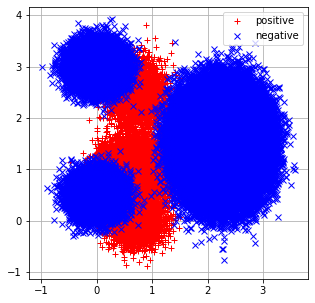

(-3.0, 3.0)

In [72]:
f, axs = plt.subplots(1, 1, figsize=(5,5))

train_x_pos_ND = train_x_ND[train_y_N==1]
train_x_neg_ND = train_x_ND[train_y_N==0]
axs.plot(train_x_pos_ND[:,0], train_x_pos_ND[:,1], 'r+', label='positive')
axs.plot(train_x_neg_ND[:,0], train_x_neg_ND[:,1], 'bx', label='negative')
axs.grid(True)
axs.legend()
plt.show()
axs.set_xlim([-3, 3])

## Get the EICU data

In [73]:
eicu_data_dir = '/cluster/tufts/hugheslab/prath01/projects/time_series_prediction/datasets/eicu/v20210610/split-by=subject_id/collapsed_features_dynamic_input_output/classifier_train_test_split_dir/'
eicu_data_csv = os.path.join(eicu_data_dir, 'x_train.csv')
eicu_df = pd.read_csv(eicu_data_csv)

eicu_dict_file = os.path.join(eicu_data_dir, 'x_dict.json')
eicu_data_dict = json.load(open(eicu_dict_file))
feature_cols = parse_feature_cols(eicu_data_dict['schema'])


In [53]:
eicu_df

,subject_id,hadm_id,icustay_id,start,stop,BUN_std_90-100,BUN_time_since_measured_90-100,BUN_count_90-100,BUN_slope_90-100,BUN_median_90-100,...,st2_max_0-100,st2_last_value_measured_0-100,st3_std_0-100,st3_time_since_measured_0-100,st3_count_0-100,st3_slope_0-100,st3_median_0-100,st3_min_0-100,st3_max_0-100,st3_last_value_measured_0-100
0,002-10052,137239,151900,-24.0,-12.0,10.0,-24.0,0.0,0.0,0.0,...,0.0,0.0,10.000000,-24.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,002-10052,137239,151900,-24.0,0.0,10.0,-24.0,0.0,0.0,0.0,...,0.0,0.0,10.000000,-24.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,002-10052,137239,151900,-24.0,12.0,10.0,-24.0,0.0,0.0,0.0,...,0.0,0.0,10.000000,-24.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,002-10052,137239,151900,-24.0,24.0,0.0,3.0,1.0,0.0,15.0,...,0.0,0.0,10.000000,-24.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,002-10052,137239,151900,-24.0,36.0,0.0,0.0,1.0,0.0,16.0,...,0.0,0.0,10.000000,-24.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428704,035-9975,2731781,3340712,-24.0,84.0,0.0,8.0,1.0,0.0,30.0,...,190.0,75.0,23.037580,2.0,76.0,0.145142,30.0,0.0,110.0,30.0
428705,035-9975,2731781,3340712,-24.0,96.0,10.0,-24.0,0.0,0.0,0.0,...,190.0,90.0,22.899347,0.0,87.0,0.243083,30.0,0.0,110.0,60.0
428706,035-9975,2731781,3340712,-24.0,108.0,0.0,8.0,1.0,0.0,31.0,...,190.0,90.0,22.629614,0.0,96.0,0.263282,30.0,0.0,110.0,50.0
428707,035-9975,2731781,3340712,-24.0,120.0,10.0,-24.0,0.0,0.0,0.0,...,190.0,65.0,23.196384,0.0,108.0,0.062871,30.0,0.0,110.0,50.0


## Merge to create semi-synthetic data

In [78]:
eicu_data_np = eicu_df[feature_cols].values
prng = np.random.RandomState(0)
shuffle_ids_eicu = prng.permutation(eicu_data_np.shape[0])

shuffle_ids_eicu_train = shuffle_ids_eicu[:N_train]
shuffle_ids_eicu_valid = shuffle_ids_eicu[N_train:N_train+N_valid]
shuffle_ids_eicu_test = shuffle_ids_eicu[N_train+N_valid:N_train+N_valid+N_test]

train_x_final = np.hstack([train_x_ND, eicu_data_np[shuffle_ids_eicu_train]])
valid_x_final = np.hstack([valid_x_ND, eicu_data_np[shuffle_ids_eicu_valid]])
test_x_final = np.hstack([test_x_ND, eicu_data_np[shuffle_ids_eicu_test]])

## Throw into dataframe and save to csv

In [79]:
final_feature_cols = ['synthetic_0', 'synthetic_1']+feature_cols
outcome_col = ['synthetic_outcome']

In [80]:
n_features = 100

final_x_train_df = pd.DataFrame(train_x_final[:, :n_features], columns=final_feature_cols[:n_features])
final_y_train_df = pd.DataFrame(train_y_N.astype(int), columns=outcome_col)

final_x_valid_df = pd.DataFrame(valid_x_final[:, :n_features], columns=final_feature_cols[:n_features])
final_y_valid_df = pd.DataFrame(valid_y_N.astype(int), columns=outcome_col)

final_x_test_df = pd.DataFrame(test_x_final[:, :n_features], columns=final_feature_cols[:n_features])
final_y_test_df = pd.DataFrame(test_y_N.astype(int), columns=outcome_col)

In [81]:
final_x_train_df

,synthetic_0,synthetic_1,BUN_count_0-100,BUN_count_90-100,BUN_last_value_measured_0-100,BUN_last_value_measured_90-100,BUN_max_0-100,BUN_max_90-100,BUN_median_0-100,BUN_median_90-100,...,gender_is_male_min_0-100,gender_is_male_min_90-100,gender_is_male_slope_0-100,gender_is_male_slope_90-100,gender_is_male_std_0-100,gender_is_male_std_90-100,gender_is_male_time_since_measured_0-100,gender_is_male_time_since_measured_90-100,gender_is_unknown_count_0-100,gender_is_unknown_count_90-100
0,0.633207,1.280461,2.0,1.0,12.0,12.0,22.0,12.0,17.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61.0,9.0
1,1.963540,1.875307,13.0,1.0,32.0,32.0,83.0,32.0,57.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.0,10.0
2,2.567876,2.081456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,10.0,10.0,-24.0,-24.0,0.0,0.0
3,2.256691,0.593574,2.0,1.0,16.0,16.0,16.0,16.0,14.5,16.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,4.0
4,1.851683,1.479845,1.0,0.0,12.0,0.0,12.0,0.0,12.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254995,2.451410,1.272825,3.0,1.0,31.0,31.0,31.0,31.0,21.0,31.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,61.0,9.0
254996,0.223462,2.705042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
254997,-0.138417,3.211534,1.0,0.0,18.0,0.0,18.0,0.0,18.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,5.0
254998,2.268298,1.437200,5.0,1.0,41.0,41.0,41.0,41.0,37.0,41.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,49.0,8.0


In [82]:
final_y_train_df

,synthetic_outcome
0,1
1,0
2,0
3,0
4,0
...,...
254995,0
254996,0
254997,0
254998,0


In [84]:
semi_synthetic_dir = '/cluster/tufts/hugheslab/prath01/projects/time_series_prediction/datasets/semi_synthetic_precision_recall_eicu/'
x_train_csv = os.path.join(semi_synthetic_dir, 'x_train.csv')
y_train_csv = os.path.join(semi_synthetic_dir, 'y_train.csv')

x_valid_csv = os.path.join(semi_synthetic_dir, 'x_valid.csv')
y_valid_csv = os.path.join(semi_synthetic_dir, 'y_valid.csv')

x_test_csv = os.path.join(semi_synthetic_dir, 'x_test.csv')
y_test_csv = os.path.join(semi_synthetic_dir, 'y_test.csv')

final_x_train_df.to_csv(x_train_csv, index=False)
final_y_train_df.to_csv(y_train_csv, index=False)

final_x_valid_df.to_csv(x_valid_csv, index=False)
final_y_valid_df.to_csv(y_valid_csv, index=False)

final_x_test_df.to_csv(x_test_csv, index=False)
final_y_test_df.to_csv(y_test_csv, index=False)

In [14]:
final_x_valid_df.shape

(513, 100)

In [15]:
final_x_test_df.shape

(513, 100)